In [1]:
import pandas as pd
from jsonlines import jsonlines
from tqdm import tqdm
import numpy as np
import pyspark
from pyspark import SparkContext
import json

In [2]:
sc = SparkContext()

23/11/17 02:45:46 WARN Utils: Your hostname, sebastien-Inspiron-7391-2n1 resolves to a loopback address: 127.0.1.1; using 192.168.1.73 instead (on interface wlp0s20f3)
23/11/17 02:45:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/17 02:45:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/17 02:45:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Load the data

In [3]:
channel_data = pd.read_csv('data/df_channels_en.tsv', sep='\t')
print(channel_data['category_cc'].unique())

category = 'Gaming'
# channel_data = channel_data[channel_data['category_cc'] == category]

['Gaming' 'Education' 'Entertainment' 'Howto & Style' 'Sports' 'Music'
 'Film and Animation' 'Comedy' 'Nonprofits & Activism' 'People & Blogs'
 'News & Politics' 'Science & Technology' 'Pets & Animals'
 'Autos & Vehicles' 'Travel & Events' nan]


In [4]:
# video_data = pd.read_json('data/climate_videos_new.jsonl', lines=True)

path_to_disk = '/Volumes/Maxtor'
path_to_disk_ubuntu = '/media/sebastien/Maxtor'
file_path = '/yt_metadata_en.jsonl'

climate_file_path = 'data/climate_videos_new.jsonl'

# pyspark_df = pyspark.pandas.read_json(path_to_disk_ubuntu + file_path)
raw_data = sc.textFile(climate_file_path)
video_data = raw_data.map(lambda x: json.loads(x))
# video_data = sc.parallelize(raw_data.take(100000)).map(lambda x: json.loads(x))
# video_data = video_data.filter(lambda x: x['categories'] == category)

# Look at channel matches in video title and description

In [5]:
channel_names = set(channel_data['name_cc'].dropna().unique().tolist())
print('Number of channels:', len(channel_names))
# print('Number of videos:', video_data.count())

# Search for presence of channel names in video title and description
def find_match(title: str, description: str, tags: str, channel_id: str):
    inter = channel_names.intersection(set(tags.split(',')))
    if len(inter) > 0:
        return list(inter)[0], channel_id
    else:
        return None
    
    # for channel_name in channel_names:
    #     if channel_name in tags:
    #         return title, channel_name
                
data = video_data.map(lambda x: find_match(x['title'], x['description'], x['tags'], x['channel_id']))
data = data.filter(lambda x: x is not None)
data = data.groupBy(lambda x: x[0]).map(lambda x: (x[0], len(x[1]), list([y[1] for y in x[1]])))
res = list(sorted(data.collect(), key=lambda item: item[1], reverse=True))

# Save as json file
file_name = 'data/channel_matches_names_climate_change.jsonl'
with jsonlines.open(file_name, 'w') as f:
    f.write_all(res)

Number of channels: 135691


# Load the graph data

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
graph_data = pd.read_json(file_name, lines=True)
graph_data.columns = ['channel_name', 'count', 'channel_ids']
graph_data = graph_data[graph_data['count'] > 1]
graph_data = graph_data[graph_data['count'] < 30]
# graph_data = graph_data[graph_data['channel_name'].apply(lambda x: len(x) > 10)]
display(graph_data)

,channel_name,count,channel_ids
240,Top 10,29,"[UCnZ36r4mdxQzIBJ46cKlPsQ, UCmeVA7qy9XsyyDc2Um..."
241,UN Environment,29,"[UCqZbKCEpqg7IZgo7N6Jc5tw, UCdrhoWKtC0CVoEvg12..."
242,create,29,"[UCqQlwYKMBuK8JuFO5dJxSmQ, UCkvmk8vmtsuwlHt265..."
243,Siemens,29,"[UCaY-4ndPCRKp60qXF7zBJ0w, UCaEEm-0s0x3MHg9jzF..."
244,Identity,29,"[UCAuUUnT6oDeKwE6v1NGQxug, UCsT0YIqwnpJCM-mx7-..."
...,...,...,...
2315,TU Delft,2,"[UC2Cn5pOKmQWrhcEFjZB8HuA, UC2Cn5pOKmQWrhcEFjZ..."
2316,Fashion Tips,2,"[UCuCXXo0FRLq_vFlNz-yLf-A, UCuCXXo0FRLq_vFlNz-..."
2317,POPSUGAR Food,2,"[UC1aJuxLHlw8bBV6mfCqVfog, UC1aJuxLHlw8bBV6mfC..."
2318,Rolling Stone,2,"[UC-3jIAlnQmbbVMV6gR7K8aQ, UCtYjvLEq6FCTWHUX_q..."


# Convert channel ids to channel names in the graph data 

In [7]:
# graph_data = graph_data.sample(1000)
channel_id_to_name = {row['channel']: row['name_cc'] for _, row in channel_data.iterrows()}
graph_data['channel_names'] = graph_data['channel_ids'].apply(lambda x: [channel_id_to_name[y] for y in x if y in channel_id_to_name])
display(graph_data['channel_names'])

240     [The Abundant World, Top10 DotCom, BoKnowsEnte...
241     [science facts in tam..., AidanRGallagher, Woo...
242     [MaxxusBricks - LEGO ..., Better Life, Veggie ...
243     [Volvo Cars, Siemens, Siemens, Siemens, Siemen...
244     [TED, TEDx Talks, TEDx Talks, TEDx Talks, TEDx...
                              ...                        
2315                                 [TU Delft, TU Delft]
2316                 [POPSUGAR Fashion, POPSUGAR Fashion]
2317                       [POPSUGAR Food, POPSUGAR Food]
2318               [The Majority Report ..., paul8kangas]
2319                 [KBDProductionsTV, KBDProductionsTV]
Name: channel_names, Length: 2080, dtype: object

# Construct the graph nodes and edegs 

In [8]:
from collections import Counter
graph_data['channel_names'] = graph_data['channel_names'].apply(lambda x: dict(Counter(x)))

In [9]:
nodes = graph_data['channel_name'].tolist()
edges = []
for i, row in graph_data.iterrows():
    edge_batch = [(row['channel_name'], channel_name, {'weight': count}) for channel_name, count in row['channel_names'].items()]
    edges.extend(edge_batch)
    
print(len(nodes), '\n', nodes[:10])
print(len(edges), '\n',edges[:10])

2080 
 ['Top 10', 'UN Environment', 'create', 'Siemens', 'Identity', 'Bill Gates', 'fresh', 'Artkala', '100%', 'Paul Beckwith']
5825 
 [('Top 10', 'The Abundant World', {'weight': 1}), ('Top 10', 'Top10 DotCom', {'weight': 1}), ('Top 10', 'BoKnowsEntertainment...', {'weight': 1}), ('Top 10', 'World According To B...', {'weight': 2}), ('Top 10', 'Mind Boggler', {'weight': 1}), ('Top 10', 'ShelterMode', {'weight': 1}), ('Top 10', 'Cereal Marshmallows', {'weight': 1}), ('Top 10', 'WatchMojo.com', {'weight': 4}), ('Top 10', 'Immigroup Inc', {'weight': 1}), ('Top 10', 'Unveiled', {'weight': 1})]


In [10]:
# Filter edges that map to themselves and edges that are not in the nodes
edges = [edge for edge in edges if edge[0] != edge[1]]
edges = [edge for edge in edges if edge[1] in nodes]
print(len(edges), edges[:10])

708 [('Top 10', 'Unveiled', {'weight': 1}), ('Top 10', 'MostAmazingTop10', {'weight': 1}), ('create', 'Exploratorium', {'weight': 1}), ('create', 'Sephora', {'weight': 1}), ('create', '5-Minute Crafts', {'weight': 1}), ('create', 'The King of Random', {'weight': 1}), ('Siemens', 'Volvo Cars', {'weight': 1}), ('Siemens', 'Fortune Magazine', {'weight': 1}), ('Siemens', 'One Young World', {'weight': 1}), ('Bill Gates', 'IET', {'weight': 1})]


# Construct the graph

In [11]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
# Calculate the degree (number of neighbors) for 
nodes_degree_0 = [node for node, degree in G.degree() if degree == 0]
G.remove_nodes_from(nodes_degree_0)

In [12]:
# Save the graph
nx.write_graphml(G, 'data/graph.graphml')
# Load the graph
G = nx.read_graphml('data/graph.graphml')
print(G)

Graph with 741 nodes and 705 edges


In [13]:
import community
partition = community.best_partition(G)
print(len(partition))

741


['Guy Brown', 'Step One Survival', 'Paul Beckwith', 'JCVdude']


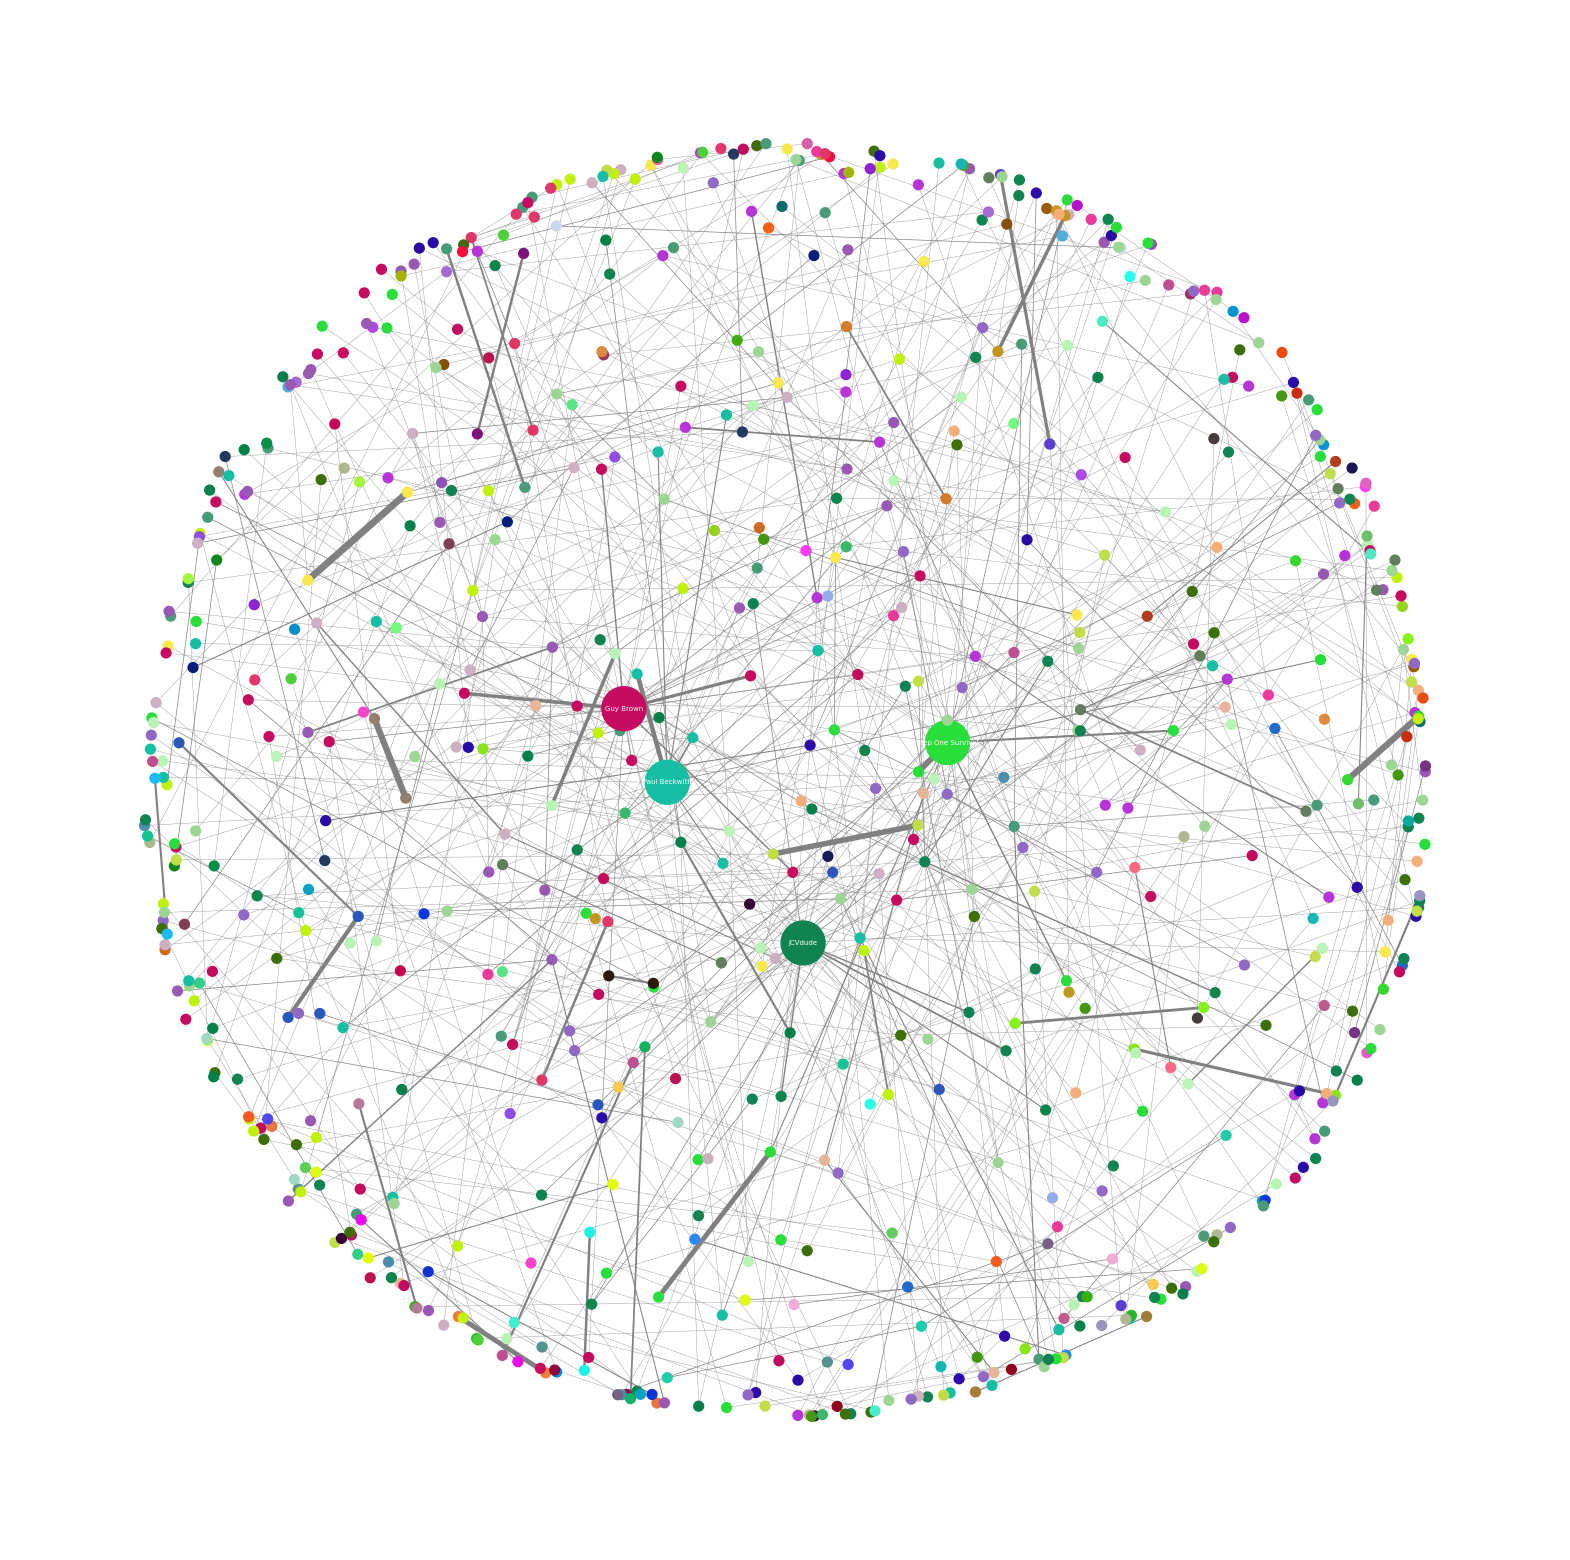

Most connected channels: {'Guy Brown': 'Guy Brown', 'Step One Survival': 'Step One Survival', 'Paul Beckwith': 'Paul Beckwith', 'JCVdude': 'JCVdude'}


In [14]:
pos = nx.spring_layout(G, k=1.5, iterations=200)

top_nodes = list(map(lambda x: x[0], sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:len(nodes) // 500]))
print(top_nodes)


# Draw nodes and edges
import random
colors = {community_id: "#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])
          for community_id in set(partition.values())}

# Extract node colors based on community membership
node_color = [colors[partition[node]] for node in G.nodes()]

# Highlight the top nodes by changing their color or size
# node_color = ['red' if node in top_nodes else 'blue' for node in G.nodes()]
node_size = [1000 if node in top_nodes else 50 for node in G.nodes()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = [weight / max(edge_weights) * 5 for weight in edge_weights]

fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(G, pos, with_labels=False, font_weight='bold', node_size=node_size, node_color=node_color, font_color='black', edge_color='gray', width=edge_weights, ax=ax)

# Show node labels for the top nodes
labels = {node: str(node) for node in top_nodes}
nx.draw_networkx_labels(G, pos, labels, font_color='white', font_size=5)

# Show the plot
plt.show()

print(f"Most connected channels: {labels}")